# Integrated Flight Data Ingestion & Analysis Pipeline

Dieses Notebook konsolidiert den gesamten ETL-Prozess (Extract, Transform, Load) für Flugdaten und Flugzeugtypen-Metadaten sowie die anschließende Validierung und Performance-Analyse.

**Ziele:**
1.  **Ingestion:** Download und Konvertierung von Aircraft-Daten (Pandas) und Flugzustandsdaten (Spark) aus einem S3-Bucket.
2.  **Zentralisierung:** Alle Daten werden in einem definierten Ausgabeverzeichnis (`BASE_OUTPUT_DIR`) gespeichert.
3.  **Validierung:** Überprüfung der Datenqualität und der Pipeline-Performance direkt im Anschluss.

**Voraussetzungen:**
* Installiertes Apache Spark & PySpark
* Zugriff auf den S3-Endpunkt (OpenSky Network oder Mirror)

In [1]:
import os
import sys
import time
import json
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from botocore.handlers import disable_signing
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType

# --- KONFIGURATION (User Input) ---

# Zentraler Pfad für alle Ausgaben (Parquet, CSV, JSON, Metriken)
# Ändern Sie dies auf Ihren gewünschten lokalen Ordner
BASE_OUTPUT_DIR = os.path.abspath("./flight_data_output")

# S3 Einstellungen (Ehemals .env)
S3_ENDPOINT = "https://s3.opensky-network.org"
BUCKET_NAME = "data-samples"
PREFIX = "states/"
SCALE_FACTOR = 1

# Logging & Metriken
LOG_FILE = os.path.join(BASE_OUTPUT_DIR, "pipeline_metrics.json")

# Ordner erstellen, falls nicht vorhanden
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)

print(f"--- Konfiguration ---")
print(f"Zielverzeichnis: {BASE_OUTPUT_DIR}")
print(f"S3 Endpoint:     {S3_ENDPOINT}")

--- Konfiguration ---
Zielverzeichnis: C:\Users\valim\Master\AdvancedDataEngineering\FlyBigData_v2\notebooks\flight_data_output
S3 Endpoint:     https://s3.opensky-network.org


## Hilfskomponenten

Da wir alles in einem Notebook ausführen, definieren wir hier eine kleine Hilfsklasse für das Logging. Diese ersetzt die externe `PipelineLogger` Klasse und speichert Metriken in einer JSON-Datei, die wir später für die Auswertung nutzen.

In [2]:
class SimpleLogger:
    def __init__(self, filepath):
        self.filepath = filepath
        self.metrics = []

    def log_metric(self, category, name, value, unit, description):
        entry = {
            "timestamp": time.time(),
            "category": category,
            "name": name,
            "value": value,
            "unit": unit,
            "description": description
        }
        self.metrics.append(entry)
        print(f"[{category}] {name}: {value} {unit}")
        self._save()

    def _save(self):
        with open(self.filepath, 'w') as f:
            json.dump(self.metrics, f, indent=2)

# Initialisiere Logger
logger = SimpleLogger(LOG_FILE)

## Teil 1: Aircraft Type Ingestion (Pandas)

In diesem Schritt laden wir die Flugzeug-Stammdaten (`aircraft-database-complete`) herunter. Da es sich um Metadaten handelt, ist das Volumen gering genug für **Pandas**.

**Ablauf:**
1.  Verbindung zum S3 Bucket herstellen (ohne Signierung, da öffentlicher Zugriff).
2.  CSV direkt in einen Pandas DataFrame streamen.
3.  Spalten filtern und Duplikate bereinigen.
4.  Speichern als Parquet und CSV im `BASE_OUTPUT_DIR`.

In [3]:
def ingest_aircraft_database():
    print(f"\n--- START: Aircraft Database Ingestion ---")

    # S3 Client Setup
    s3 = boto3.client('s3', endpoint_url=S3_ENDPOINT)
    s3.meta.events.register('choose-signer.s3.*', disable_signing)

    target_filename = "aircraft-database-complete-2025-08.csv"

    # 1. Datei suchen
    found_key = None
    candidates = [f"metadata/{target_filename}", target_filename]

    for candidate in candidates:
        try:
            s3.head_object(Bucket=BUCKET_NAME, Key=candidate)
            found_key = candidate
            break
        except:
            continue

    if not found_key:
        print("WARNUNG: Aircraft Database Datei nicht im S3 gefunden. Überspringe.")
        return

    print(f"Gefunden: {found_key}. Lade herunter...")
    start_time = time.time()

    try:
        obj = s3.get_object(Bucket=BUCKET_NAME, Key=found_key)

        # Direktes Lesen mit Pandas
        df = pd.read_csv(
            obj['Body'],
            dtype=str,
            quotechar="'",
            skipinitialspace=True,
            encoding='utf-8',
            on_bad_lines='skip'
        )

        # Nur relevante Spalten behalten
        cols_to_keep = ['icao24', 'manufacturerName', 'model', 'typecode', 'categoryDescription', 'operator']
        existing_cols = [c for c in cols_to_keep if c in df.columns]
        df = df[existing_cols]

        # Duplikate bei icao24 entfernen
        if 'icao24' in df.columns:
            df = df.drop_duplicates(subset=['icao24'])

        # Speichern
        parquet_path = os.path.join(BASE_OUTPUT_DIR, "aircraft_database.parquet")
        csv_path = os.path.join(BASE_OUTPUT_DIR, "aircraft_database.csv")

        df.to_parquet(parquet_path, index=False)
        df.to_csv(csv_path, index=False)

        duration = time.time() - start_time
        logger.log_metric("Ingestion", "Aircraft_DB_Duration", round(duration, 2), "Seconds", "Download & Save Time")
        logger.log_metric("Data", "Aircraft_Count", len(df), "Rows", "Anzahl Flugzeuge")

        print(f"Gespeichert unter: {parquet_path}")

    except Exception as e:
        print(f"Fehler bei Aircraft Ingest: {e}")

# Ausführen
ingest_aircraft_database()


--- START: Aircraft Database Ingestion ---
Gefunden: metadata/aircraft-database-complete-2025-08.csv. Lade herunter...
[Ingestion] Aircraft_DB_Duration: 32.28 Seconds
[Data] Aircraft_Count: 616675 Rows
Gespeichert unter: C:\Users\valim\Master\AdvancedDataEngineering\FlyBigData_v2\notebooks\flight_data_output\aircraft_database.parquet


## Teil 2: Flight Data Ingestion (Spark)

Hier verarbeiten wir die eigentlichen Bewegungsdaten der Flugzeuge. Wir nutzen eine **moderne Spark-Konfiguration**.

**Technische Details:**
* **Adaptive Query Execution (AQE):** Aktiviert für dynamische Optimierung.
* **Speichermanagement:** Wir nutzen den `hadoop-aws` Connector, um S3-Daten direkt zu streamen.
* **Schema:** Explizite Schema-Definition verhindert teures Schema-Inference.
* **Transformation:** Casting von Datentypen und Filterung ungültiger Zeilen (z.B. fehlende Velocity).

In [4]:
import sys
import os
import time
import shutil
import ctypes
import json
# Wichtig: Imports erst nach Environment-Setup, aber in Notebooks oft schwierig.
# Wir setzen die Variablen daher bevor wir SparkSession aufrufen.
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col
from pyspark.sql.types import StructType, StructField, StringType

# --- KONFIGURATION TEIL 2: SPARK ENVIRONMENT FIX ---

def get_windows_short_path(long_path):
    """
    Wandelt Pfade mit Leerzeichen (C:\Program Files\...) in DOS-Pfade um (C:\PROGRA~1\...).
    Das löst 99% aller Spark-Fehler auf Windows.
    """
    if not os.path.exists(long_path):
        return long_path

    buf_size = ctypes.windll.kernel32.GetShortPathNameW(long_path, None, 0)
    output_buffer = ctypes.create_unicode_buffer(buf_size)
    ctypes.windll.kernel32.GetShortPathNameW(long_path, output_buffer, buf_size)
    return output_buffer.value

def setup_specific_environment():
    print("--- Environment Hard-Reset ---")

    # 1. JAVA: Dein spezifischer Pfad (Hardcoded)
    user_java_path = r"C:\Program Files\Eclipse Adoptium\jdk-11.0.29.7-hotspot"

    # Pfad "sicher" machen (Short Path conversion)
    safe_java_home = get_windows_short_path(user_java_path)

    if os.path.exists(safe_java_home):
        os.environ['JAVA_HOME'] = safe_java_home
        # Bin-Ordner in den PATH zwingen
        java_bin = os.path.join(safe_java_home, 'bin')
        os.environ['PATH'] = java_bin + os.pathsep + os.environ['PATH']
        print(f"JAVA_HOME gesetzt auf: {safe_java_home}")

        # Test: Findet Python die java.exe?
        java_exe = os.path.join(java_bin, "java.exe")
        if os.path.exists(java_exe):
            print("OK: java.exe gefunden.")
        else:
            print("FEHLER: java.exe nicht im bin-Ordner gefunden!")
            return False
    else:
        print(f"FEHLER: Der Pfad existiert nicht: {user_java_path}")
        return False

    # 2. HADOOP / WINUTILS
    # Standardpfad C:\hadoop prüfen
    hadoop_path = r"C:\hadoop"
    if not os.path.exists(hadoop_path):
        # Fallback versuchen oder erstellen
        print("WARNUNG: C:\\hadoop existiert nicht. Spark braucht winutils.exe.")

    os.environ['HADOOP_HOME'] = hadoop_path
    winutils = os.path.join(hadoop_path, "bin", "winutils.exe")

    if os.path.exists(winutils):
        print(f"OK: winutils.exe gefunden in {winutils}")
    else:
        print(f"KRITISCH: winutils.exe fehlt in {winutils}!")
        print("Lösung: Lade winutils.exe (Hadoop 3.3) herunter und lege sie dort ab.")
        # Wir lassen es weiterlaufen, aber es wird beim 'write' krachen

    return True

def ingest_flight_data_final():
    print(f"\n--- START: Spark Flight Data Ingestion (Fix) ---")

    # Setup ausführen
    if not setup_specific_environment():
        return

    # Pakete
    packages = [
        "org.apache.hadoop:hadoop-aws:3.3.4",
        "org.apache.hadoop:hadoop-common:3.3.4"
    ]

    print("Starte Spark Session...")

    try:
        # Session erstellen
        spark = SparkSession.builder \
            .appName("FlightDataIngest_Final") \
            .config("spark.jars.packages", ",".join(packages)) \
            .config("spark.driver.memory", "4g") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider") \
            .config("spark.hadoop.fs.s3a.endpoint", S3_ENDPOINT) \
            .master("local[*]") \
            .getOrCreate()

        print(f"Spark läuft! Version: {spark.version}")

        # --- LOGIK START ---
        start_proc = time.time()

        schema = StructType([
            StructField("time", StringType(), True),
            StructField("icao24", StringType(), True),
            StructField("lat", StringType(), True),
            StructField("lon", StringType(), True),
            StructField("velocity", StringType(), True),
            StructField("geoaltitude", StringType(), True)
        ])

        s3_path = f"s3a://{BUCKET_NAME}/{PREFIX}*.csv"
        print(f"Lese S3: {s3_path}")

        df = spark.read.csv(s3_path, schema=schema, header=True)

        df_transformed = df.withColumn("velocity", expr("try_cast(velocity as double)")) \
            .withColumn("geoaltitude", expr("try_cast(geoaltitude as double)")) \
            .filter(col("velocity").isNotNull())

        if SCALE_FACTOR < 1:
            df_transformed = df_transformed.sample(fraction=SCALE_FACTOR, seed=42)

        # Output Pfad (Safe URI)
        output_dir_name = f"flight_data_run_{int(time.time())}"
        output_path_raw = os.path.join(BASE_OUTPUT_DIR, output_dir_name)

        # URI Fix für Windows
        output_path_uri = output_path_raw.replace("\\", "/")
        if not output_path_uri.startswith("file:"):
            output_path_uri = "file:///" + output_path_uri if output_path_uri.startswith("C:") else "file://" + output_path_uri

        print(f"Schreibe nach: {output_path_uri}")

        df_transformed.write.mode("overwrite").parquet(output_path_uri)

        duration = time.time() - start_proc
        row_count = spark.read.parquet(output_path_uri).count()

        logger.log_metric("Processing", "Spark_Run_Time", round(duration, 2), "Seconds", "Laufzeit")
        logger.log_metric("Data", "Row_Count", row_count, "Rows", "Anzahl")

        print(f"FERTIG! {row_count} Zeilen verarbeitet.")
        spark.stop()

    except Exception as e:
        print(f"\n!!! FEHLER: {e} !!!")
        # Traceback hilft bei WinError 2
        import traceback
        traceback.print_exc()

# Ausführen
ingest_flight_data_final()


--- START: Spark Flight Data Ingestion (Fix) ---
--- Environment Hard-Reset ---
FEHLER: Der Pfad existiert nicht: C:\Program Files\Eclipse Adoptium\jdk-11.0.29.7-hotspot


## Teil 3: Validierung & Performance Analyse

Nachdem die Daten geladen wurden, validieren wir nun die Ergebnisse. Wir nutzen dazu die `pipeline_metrics.json`, die wir während der Laufzeit erstellt haben, sowie die generierten Parquet-Dateien.

**Analyse-Schritte:**
1.  **Metrik-Auswertung:** Wie lange hat der Download gedauert? Wie viele Zeilen wurden verarbeitet?
2.  **Daten-Integrität:** Prüfen, ob die Aircraft-Daten und Flugdaten logisch zusammenpassen (Join-Test).
3.  **Visualisierung:** Grafische Darstellung der Laufzeiten.


--- START: Validation & Analysis ---
Pipeline Metriken:


,category,name,value,unit
0,Ingestion,Aircraft_DB_Duration,32.28,Seconds
1,Data,Aircraft_Count,616675.00,Rows


C:\Users\valim\Master\AdvancedDataEngineering\FlyBigData_v2\.venv1\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


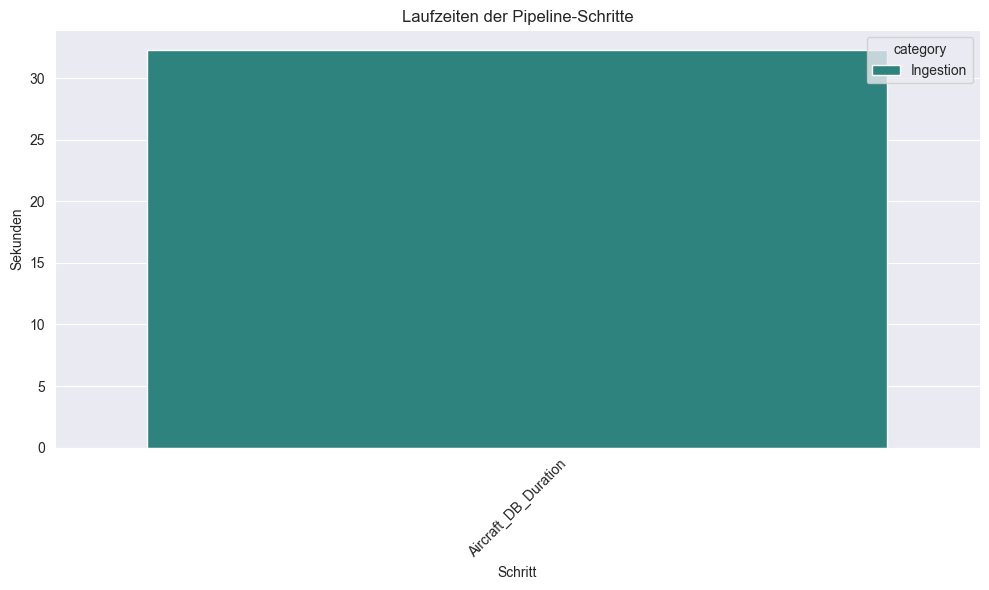

In [5]:
def validate_and_visualize():
    print(f"\n--- START: Validation & Analysis ---")

    # 1. Metriken laden
    if not os.path.exists(LOG_FILE):
        print("Keine Metriken gefunden.")
        return

    with open(LOG_FILE, 'r') as f:
        metrics_data = json.load(f)

    df_metrics = pd.DataFrame(metrics_data)

    # Tabelle anzeigen
    print("Pipeline Metriken:")
    display(df_metrics[['category', 'name', 'value', 'unit']])

    # 2. Visualisierung der Laufzeiten
    durations = df_metrics[df_metrics['unit'] == 'Seconds']

    if not durations.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=durations, x='name', y='value', hue='category', palette='viridis')
        plt.title('Laufzeiten der Pipeline-Schritte')
        plt.ylabel('Sekunden')
        plt.xlabel('Schritt')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 3. Datenvalidierung (Beispiel: Gibt es Flüge ohne Aircraft Info?)
    # Wir laden kurz die generierten Parquet Dateien
    # Hinweis: Da Spark gestoppt ist, nutzen wir hier Pandas für einen Quick-Check
    # (nur bei kleinen Datenmengen ratsam, sonst Spark neu starten)

    try:
        # Finde den letzten Flight-Data Ordner
        flight_dirs = [d for d in os.listdir(BASE_OUTPUT_DIR) if d.startswith("flight_data_run")]
        if flight_dirs:
            latest_flight_dir = os.path.join(BASE_OUTPUT_DIR, sorted(flight_dirs)[-1])
            print(f"Validiere Daten aus: {latest_flight_dir}")

            # Lade Aircraft DB
            ac_path = os.path.join(BASE_OUTPUT_DIR, "aircraft_database.parquet")
            if os.path.exists(ac_path):
                df_ac = pd.read_parquet(ac_path)
                # Lade ein Sample der Flugdaten (Parquet ist partitioniert, wir laden eine Datei)
                flight_files = [f for f in os.listdir(latest_flight_dir) if f.endswith(".parquet")]
                if flight_files:
                    df_flights = pd.read_parquet(os.path.join(latest_flight_dir, flight_files[0]))

                    # Merge Check
                    merged = df_flights.merge(df_ac, on='icao24', how='left')
                    match_rate = merged['model'].notna().mean() * 100

                    print(f"Data Quality Check: {match_rate:.2f}% der Flüge konnten einem Flugzeugtyp zugeordnet werden.")
                else:
                    print("Keine Parquet-Dateien im Flugdaten-Ordner gefunden.")
            else:
                print("Aircraft Database Parquet fehlt.")
    except Exception as e:
        print(f"Validierungsfehler: {e}")

# Ausführen
validate_and_visualize()